# **Data process**

## Đổi tên các cột concat()

In [1]:
import pandas as pd

anno_df = pd.read_csv('/kaggle/input/project2-cs114-data/wecode.data/annonimized.csv')

anno_df.rename(columns={
    "concat('it001',`assignment_id`)": 'a_id',
    "concat('it001',`problem_id`)": 'p_id',
    "concat('it001', username)": 'username',
    "concat('it001',`language_id`)": 'lang_id',
}, inplace=True)

anno_df.head()

,a_id,p_id,username,is_final,status,pre_score,coefficient,lang_id,created_at,updated_at,judgement
0,90ce27571176d87961b565d5ef4b3de33ede04ac,789454427dd4097a14749e3dde63346b7a8d3811,ed9eaeb6a707f50154024b24d7efcb874a9795dd,0,SCORE,0,100,it0012,10-09 08:02:04,10-09 08:06:58,"{""times"":[0,0,0,0,0,0,0,0,0,0],""mems"":[0,0,0,0..."
1,90ce27571176d87961b565d5ef4b3de33ede04ac,789454427dd4097a14749e3dde63346b7a8d3811,ed9eaeb6a707f50154024b24d7efcb874a9795dd,0,SCORE,0,100,it0012,10-09 08:04:41,10-09 08:04:51,"{""times"":[0,0,0,0,0,0,0,0,0,0],""mems"":[0,0,0,0..."
2,90ce27571176d87961b565d5ef4b3de33ede04ac,789454427dd4097a14749e3dde63346b7a8d3811,ed9eaeb6a707f50154024b24d7efcb874a9795dd,1,SCORE,10000,100,it0012,10-09 08:06:49,10-09 08:06:58,"{""times"":[0,0,0,0,0,0,0,0,0,0],""mems"":[0,0,0,0..."
3,90ce27571176d87961b565d5ef4b3de33ede04ac,bf96fbdc5f499538c3e2bfbec5779c8a14b0a9ff,ed9eaeb6a707f50154024b24d7efcb874a9795dd,1,SCORE,10000,100,it0012,10-09 08:47:52,10-09 08:48:01,"{""times"":[0,0,0,0,0,0,0,0,0,0],""mems"":[0,0,0,0..."
4,90ce27571176d87961b565d5ef4b3de33ede04ac,7a6e5ca470ff47c3b5048f240c4738de71010c78,ed9eaeb6a707f50154024b24d7efcb874a9795dd,1,SCORE,10000,100,it0012,10-09 09:19:35,10-09 09:19:45,"{""times"":[0,0,0,0,0,0,0,0,0,0],""mems"":[0,0,0,0..."


## Xử lí judgement

In [2]:
import json

def safe_parse_judgement(j):
    try:
        data = json.loads(j)
        return pd.Series({
            'times': data.get('times', []),
            'mems': data.get('mems', []),
            'verdicts': data.get('verdicts', {})
        })
    except:
        return pd.Series({'times': [], 'mems': [], 'verdicts': {}})

# Giả sử df là DataFrame bạn đang dùng, với cột 'judgement' là chuỗi JSON
# Chuyển cột 'judgement' thành dict
anno_df[['times', 'mems', 'verdicts']] = anno_df['judgement'].apply(safe_parse_judgement)
anno_df.drop('judgement', axis=1, inplace=True)
anno_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295198 entries, 0 to 295197
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   a_id         295198 non-null  object
 1   p_id         295198 non-null  object
 2   username     295198 non-null  object
 3   is_final     295198 non-null  int64 
 4   status       295198 non-null  object
 5   pre_score    295198 non-null  int64 
 6   coefficient  295198 non-null  int64 
 7   lang_id      295198 non-null  object
 8   created_at   295198 non-null  object
 9   updated_at   295198 non-null  object
 10  times        295198 non-null  object
 11  mems         295198 non-null  object
 12  verdicts     295198 non-null  object
dtypes: int64(3), object(10)
memory usage: 29.3+ MB


# **Trích xuất đặc trưng sinh viên**

## Đếm số lượng assignment đã tham gia

In [3]:
num_assignments = (
    anno_df[['username', 'a_id']]
    .drop_duplicates()
    .groupby('username')
    .size()
    .reset_index(name='num_assignments')
)

num_assignments

,username,num_assignments
0,00b6dd4fc7eb817e03708c532016ef30ce564a61,7
1,00bef8afee8f3c595d535c9c03c490cac1a4f021,9
2,01122b3ef7e59b84189e65985305f575d6bdf83c,7
3,0134f9f410c65ad0e8c2254a7e9288670e02a183,4
4,013de369c439ab0ead8aa7da64423aa395a8be39,8
...,...,...
1484,feb8a2859a011c59efd22ed419cb69288fe03627,9
1485,fef4a3263ed9a8ab14d457694bb8fd86ccd98312,6
1486,ff12d6e2ab80696ed8e22fbe5497e96c68d29076,6
1487,ff3fa2ec64294f37ae968159f810ebeda7966c51,7


## Đếm số lượng cột Status là SCORE và Error

In [4]:
# Lọc những dòng có status là "Compilation Error"
filtered_df = anno_df[anno_df['status'] == 'SCORE']

# Đếm số lượng theo từng username
num_score = filtered_df.groupby('username').size().reset_index(name='score_count')

num_score.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1475 entries, 0 to 1474
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   username     1475 non-null   object
 1   score_count  1475 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 23.2+ KB


In [5]:
# Lọc những dòng có status là "Compilation Error"
filtered_df = anno_df[(anno_df['status'] == 'Compilation Error') | (anno_df['status'] == 'Syntax Error')]

# Đếm số lượng theo từng username
num_error = filtered_df.groupby('username').size().reset_index(name='compilation_error_count')

num_error.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1428 entries, 0 to 1427
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   username                 1428 non-null   object
 1   compilation_error_count  1428 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 22.4+ KB


## Số lần submit ứng với user

In [6]:
num_submit= anno_df['username'].value_counts()
num_submit_df = num_submit.reset_index()
num_submit_df.columns = ['username', 'num_submit']

num_submit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1489 entries, 0 to 1488
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   username    1489 non-null   object
 1   num_submit  1489 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 23.4+ KB


## Số problem hoàn thành

In [7]:
# num_completed_problems = anno_df[anno_df['is_final'] == 1].groupby('username')['p_id'].nunique().reset_index(name='num_completed_problems')

# num_completed_problems

num_completed_problems = (
    anno_df[anno_df['pre_score'] == 10000]
    .drop_duplicates(subset=['username', 'p_id'])
    .groupby('username')
    .size()
    .reset_index(name='num_completed_problems')
)

num_completed_problems

,username,num_completed_problems
0,00b6dd4fc7eb817e03708c532016ef30ce564a61,46
1,00bef8afee8f3c595d535c9c03c490cac1a4f021,72
2,01122b3ef7e59b84189e65985305f575d6bdf83c,58
3,0134f9f410c65ad0e8c2254a7e9288670e02a183,47
4,013de369c439ab0ead8aa7da64423aa395a8be39,44
...,...,...
1444,feb8a2859a011c59efd22ed419cb69288fe03627,34
1445,fef4a3263ed9a8ab14d457694bb8fd86ccd98312,74
1446,ff12d6e2ab80696ed8e22fbe5497e96c68d29076,99
1447,ff3fa2ec64294f37ae968159f810ebeda7966c51,30


## Số problem hoàn thành trễ

In [8]:
num_late_submit = (
    anno_df[(anno_df['coefficient'] < 100) & (anno_df['pre_score'] == 10000)]
    .drop_duplicates(subset=['username', 'p_id'])
    .groupby('username')
    .size()
    .reset_index(name='num_late_submit')
)

num_late_submit

,username,num_late_submit
0,0155f91fe242fe55e1af631b0f0afbe9938b185c,1
1,052039d5c5915699359b1d549b36ea69330c0ac3,1
2,05b134c1a682085880fb7ce76d221a48955e5b8a,2
3,0a9b6ec3e82e8a2527b21eb3420a6d9b72f4f71e,9
4,0aad9682c3c4280eb05dbd27e6cab55f4b1ae4b4,1
...,...,...
91,f7875ec1207504a229cd9b5ca132437c6bdd6a4d,2
92,f86b9fba1d59be7c864d4f23d0c7674113a27cab,2
93,f9491b0ab4aee90c428545e0e315a3af1f827595,2
94,f9f4d4ef2a3de006bd037db9eb160ab8e51c79f2,9


## Trung bình pre_score và coefficient

In [9]:
mean_scores = anno_df.groupby('username')[['pre_score', 'coefficient']].mean().reset_index()
mean_scores

,username,pre_score,coefficient
0,00b6dd4fc7eb817e03708c532016ef30ce564a61,5504.149660,100.000000
1,00bef8afee8f3c595d535c9c03c490cac1a4f021,5488.552124,100.000000
2,01122b3ef7e59b84189e65985305f575d6bdf83c,5973.753846,100.000000
3,0134f9f410c65ad0e8c2254a7e9288670e02a183,5952.760000,100.000000
4,013de369c439ab0ead8aa7da64423aa395a8be39,6474.448598,97.196262
...,...,...,...
1484,feb8a2859a011c59efd22ed419cb69288fe03627,5581.081081,100.000000
1485,fef4a3263ed9a8ab14d457694bb8fd86ccd98312,6204.557692,100.000000
1486,ff12d6e2ab80696ed8e22fbe5497e96c68d29076,4998.466819,100.000000
1487,ff3fa2ec64294f37ae968159f810ebeda7966c51,4343.329787,100.000000


## Số bài khó hoàn thành

In [10]:
completed = (
    anno_df[anno_df['pre_score'] == 10000]
    .drop_duplicates(subset=['username', 'a_id', 'p_id'])
)

total_users_per_aid = (
    anno_df[['username', 'a_id']]
    .drop_duplicates()
    .groupby('a_id')
    .size()
    .reset_index(name='total_users')
)

num_completed_per_problem = (
    completed.groupby(['a_id', 'p_id'])['username']
    .nunique()
    .reset_index(name='num_users_completed')
)

completion_rate_df = num_completed_per_problem.merge(total_users_per_aid, on='a_id')
completion_rate_df['completion_rate'] = completion_rate_df['num_users_completed'] / completion_rate_df['total_users']

In [11]:
# def classify_difficulty(rate):
#     if rate >= 0.7:
#         return 'easy'
#     elif rate >= 0.4:
#         return 'medium'
#     elif rate >= 0.2:
#         return 'hard'
#     else:
#         return 'ex_hard'

def classify_difficulty(rate):
    if rate >= 0.8:
        return 'easy'
    elif rate >= 0.4:
        return 'medium'
    else:
        return 'hard'

completion_rate_df['difficulty'] = completion_rate_df['completion_rate'].apply(classify_difficulty)

completed_with_difficulty = completed.merge(
    completion_rate_df[['a_id', 'p_id', 'difficulty']],
    on=['a_id', 'p_id'],
    how='left'
)

num_submit_dif = (
    completed_with_difficulty
    .groupby(['username', 'difficulty'])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

# Đảm bảo đủ 3 cột
for col in ['easy', 'medium', 'hard']:
    if col not in num_submit_dif.columns:
        num_submit_dif[col] = 0

num_submit_dif

difficulty,username,easy,hard,medium
0,00b6dd4fc7eb817e03708c532016ef30ce564a61,35,0,12
1,00bef8afee8f3c595d535c9c03c490cac1a4f021,60,0,12
2,01122b3ef7e59b84189e65985305f575d6bdf83c,31,14,14
3,0134f9f410c65ad0e8c2254a7e9288670e02a183,34,0,13
4,013de369c439ab0ead8aa7da64423aa395a8be39,45,0,13
...,...,...,...,...
1444,feb8a2859a011c59efd22ed419cb69288fe03627,30,0,4
1445,fef4a3263ed9a8ab14d457694bb8fd86ccd98312,67,5,3
1446,ff12d6e2ab80696ed8e22fbe5497e96c68d29076,102,0,0
1447,ff3fa2ec64294f37ae968159f810ebeda7966c51,26,1,3


## Số lần submit cho mỗi problem

In [12]:
submit_per_problem = pd.merge(num_submit_df, num_completed_problems, on='username', how='outer')

# Tính toán
submit_per_problem['submit_per_problem'] = submit_per_problem['num_submit'] / (submit_per_problem['num_completed_problems'])

submit_per_problem.drop(['num_submit', 'num_completed_problems'], axis=1, inplace=True)

print(submit_per_problem.isnull().sum())

submit_per_problem.fillna(0, inplace=True)

print(submit_per_problem.isnull().sum())

submit_per_problem

username               0
submit_per_problem    40
dtype: int64
username              0
submit_per_problem    0
dtype: int64


,username,submit_per_problem
0,00b6dd4fc7eb817e03708c532016ef30ce564a61,3.195652
1,00bef8afee8f3c595d535c9c03c490cac1a4f021,3.597222
2,01122b3ef7e59b84189e65985305f575d6bdf83c,3.362069
3,0134f9f410c65ad0e8c2254a7e9288670e02a183,2.127660
4,013de369c439ab0ead8aa7da64423aa395a8be39,2.431818
...,...,...
1484,feb8a2859a011c59efd22ed419cb69288fe03627,2.176471
1485,fef4a3263ed9a8ab14d457694bb8fd86ccd98312,3.513514
1486,ff12d6e2ab80696ed8e22fbe5497e96c68d29076,4.414141
1487,ff3fa2ec64294f37ae968159f810ebeda7966c51,3.133333


## Thời gian trung bình làm 1 problem 

In [13]:
# Đây là sample chứng tỏ đây là năm nhuận với 2-29 nên sẽ thêm 2024 vào các sample thiếu năm

anno_df.iloc[182684]

a_id                    1bec7c0b6a9bd8f556a8554c5012dcb778460bac
p_id                    f6332fbfbd01c31062bfe102deec29525aabec5a
username                0f0664021ebbec70b1d3bb5a5419e22507179671
is_final                                                       0
status                                                     SCORE
pre_score                                                      0
coefficient                                                  100
lang_id                                                   it0012
created_at                                        02-29 01:25:00
updated_at                                        02-29 01:26:38
times          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
mems           [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
verdicts                                           {'WRONG': 20}
Name: 182684, dtype: object

In [14]:
# Thêm vào cột time_diff

import re 

LEAP_YEAR = "2024"  # Năm nhuận gần nhất

created_raw = anno_df['created_at'].copy()
updated_raw = anno_df['updated_at'].copy()

def ensure_year(date_str):
    if pd.isna(date_str):
        return date_str
    # Nếu đã có năm → giữ nguyên
    if re.search(r'\b\d{4}\b', date_str):
        return date_str
    # Nếu không có năm → thêm năm nhuận
    return f"{LEAP_YEAR} {date_str}"

# Áp dụng hàm mới
anno_df['created_at'] = created_raw.apply(ensure_year)
anno_df['updated_at'] = updated_raw.apply(ensure_year)

# Chuyển về datetime
anno_df['created_at'] = pd.to_datetime(anno_df['created_at'], errors='coerce')
anno_df['updated_at'] = pd.to_datetime(anno_df['updated_at'], errors='coerce')

# Tính time_diff (đơn vị giây)
anno_df['time_diff'] = (anno_df['updated_at'] - anno_df['created_at']).dt.total_seconds()

# Chỉ giữ time_diff nếu is_final == 1
anno_df['time_diff'] = anno_df['time_diff'].where(anno_df['is_final'] == 1)

In [15]:
# Bước 1: Nhóm theo username và p_id, rồi tính thời gian trung bình mỗi cặp
user_p_mean = (
    anno_df
    .groupby(['username', 'p_id'])['time_diff']
    .mean()
    .reset_index(name='avg_time_per_problem')
)

# Bước 2: Tính trung bình toàn bộ các p_id của từng user
user_mean_time = (
    user_p_mean
    .groupby('username')['avg_time_per_problem']
    .mean()
    .reset_index(name='avg_time_per_user')
)

user_mean_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1489 entries, 0 to 1488
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   username           1489 non-null   object 
 1   avg_time_per_user  1488 non-null   float64
dtypes: float64(1), object(1)
memory usage: 23.4+ KB


# **Visualize data để tìm thêm đặc trưng ẩn**

In [16]:
# Chuyển toàn bộ created_at sang datetime một lần duy nhất
anno_temp = anno_df.copy()
# xử lý năm nhuận
anno_temp['created_at_with_year'] = anno_temp['created_at']
anno_temp['time_obj'] = pd.to_datetime(anno_temp['created_at_with_year'], format='%Y-%m-%d %H:%M:%S').dt.time

# Tính số phút trong ngày bằng vectorization
anno_temp['time_in_minutes'] = (
    anno_temp['time_obj'].apply(lambda t: t.hour * 60 + t.minute + t.second / 60.0)
)

# username | created_at | time_obj | time_in_minutes
submit_time = anno_temp[['username', 'time_in_minutes']]
submit_time_list = anno_temp['time_in_minutes']
bins= range(0,1441, 60)
labels = range(24)
bin_series = pd.cut(submit_time_list, bins=bins, labels=labels, right=False)
# Đếm số lượng trong mỗi bin
bin_counts = bin_series.value_counts().sort_index()

# Đảm bảo đủ 24 bin (kể cả bin không có giá trị)
bin_counts_full = bin_counts.reindex(labels, fill_value=0)
bin_counts_df = bin_counts_full.reset_index()
bin_counts_df.columns = ['hour', 'num_submit']


# submit_time_by_group = submit_time.groupby('username')['time_in_minutes'].apply(list).reset_index(name='submit_time')
# submit_time_by_group

## Submit on sunday

In [17]:
anno_temp['day_submit'] = pd.to_datetime(anno_temp['created_at_with_year'], format='%Y-%m-%d %H:%M:%S').dt.day_name()
anno_temp['sunday_submit'] = (anno_temp['day_submit'] == 'Sunday').astype(int)
sunday_submit_df = anno_temp.groupby('username')['sunday_submit'].sum().reset_index(name='num_sunday_submit')
sunday_submit_df

,username,num_sunday_submit
0,00b6dd4fc7eb817e03708c532016ef30ce564a61,3
1,00bef8afee8f3c595d535c9c03c490cac1a4f021,7
2,01122b3ef7e59b84189e65985305f575d6bdf83c,19
3,0134f9f410c65ad0e8c2254a7e9288670e02a183,11
4,013de369c439ab0ead8aa7da64423aa395a8be39,0
...,...,...
1484,feb8a2859a011c59efd22ed419cb69288fe03627,0
1485,fef4a3263ed9a8ab14d457694bb8fd86ccd98312,18
1486,ff12d6e2ab80696ed8e22fbe5497e96c68d29076,84
1487,ff3fa2ec64294f37ae968159f810ebeda7966c51,41


## Time of day related features

In [18]:
# time of day
anno_temp['hour_submit'] = pd.to_datetime(anno_temp['created_at_with_year'], format='%Y-%m-%d %H:%M:%S').dt.hour
anno_temp['morning'] = ((anno_temp['hour_submit'] >= 6) & (anno_temp['hour_submit'] < 12)).astype(int)
anno_temp['afternoon'] = ((anno_temp['hour_submit'] >= 12) & (anno_temp['hour_submit'] < 18)).astype(int)
anno_temp['evening'] = (anno_temp['hour_submit'] >= 18).astype(int)
anno_temp['night'] = (anno_temp['hour_submit'] < 6).astype(int)
time_of_day_df = anno_temp.groupby('username')[['morning', 'afternoon', 'evening', 'night']].sum().reset_index()
time_of_day_df

,username,morning,afternoon,evening,night
0,00b6dd4fc7eb817e03708c532016ef30ce564a61,28,15,1,103
1,00bef8afee8f3c595d535c9c03c490cac1a4f021,103,123,0,33
2,01122b3ef7e59b84189e65985305f575d6bdf83c,77,95,1,22
3,0134f9f410c65ad0e8c2254a7e9288670e02a183,50,32,0,18
4,013de369c439ab0ead8aa7da64423aa395a8be39,84,19,0,4
...,...,...,...,...,...
1484,feb8a2859a011c59efd22ed419cb69288fe03627,39,12,9,14
1485,fef4a3263ed9a8ab14d457694bb8fd86ccd98312,32,88,0,140
1486,ff12d6e2ab80696ed8e22fbe5497e96c68d29076,114,255,0,68
1487,ff3fa2ec64294f37ae968159f810ebeda7966c51,15,56,0,23


## Balance day-night submit

In [19]:
# balance day-night submit
# cột 'balance' càng lệch 0 thì càng thiếu cân bằng. Âm thì thường nộp đêm, dương thì thường nộp sáng
total_submit = time_of_day_df[['morning', 'afternoon', 'evening', 'night']].sum(axis=1)
day_night_df = time_of_day_df.copy()
day_night_df['morning'] /= total_submit
day_night_df['afternoon'] /= total_submit
day_night_df['evening'] /= total_submit
day_night_df['night'] /= total_submit
day_night_df['balance'] = (day_night_df['morning'] - day_night_df['night'] + day_night_df['afternoon'] - day_night_df['evening'])
day_night_df

,username,morning,afternoon,evening,night,balance
0,00b6dd4fc7eb817e03708c532016ef30ce564a61,0.190476,0.102041,0.006803,0.700680,-0.414966
1,00bef8afee8f3c595d535c9c03c490cac1a4f021,0.397683,0.474903,0.000000,0.127413,0.745174
2,01122b3ef7e59b84189e65985305f575d6bdf83c,0.394872,0.487179,0.005128,0.112821,0.764103
3,0134f9f410c65ad0e8c2254a7e9288670e02a183,0.500000,0.320000,0.000000,0.180000,0.640000
4,013de369c439ab0ead8aa7da64423aa395a8be39,0.785047,0.177570,0.000000,0.037383,0.925234
...,...,...,...,...,...,...
1484,feb8a2859a011c59efd22ed419cb69288fe03627,0.527027,0.162162,0.121622,0.189189,0.378378
1485,fef4a3263ed9a8ab14d457694bb8fd86ccd98312,0.123077,0.338462,0.000000,0.538462,-0.076923
1486,ff12d6e2ab80696ed8e22fbe5497e96c68d29076,0.260870,0.583524,0.000000,0.155606,0.688787
1487,ff3fa2ec64294f37ae968159f810ebeda7966c51,0.159574,0.595745,0.000000,0.244681,0.510638


## Hard problems attempts

In [20]:
# Tìm ra những bài khó

def check_verdicts(x):
    try:
        t = list(x)
        if len(t) == 0:
            return True
    except:
        return False

submit_df = anno_df[['username', 'a_id', 'p_id', 'is_final', 'status', 'verdicts']]
print(f"submit_df : {len(submit_df)}")

problems_df = submit_df.drop_duplicates(subset=['a_id', 'p_id']).drop(['is_final', 'status', 'username', 'verdicts'], axis=1)
print(f"problems_df : {len(problems_df)}")

# Tổng số người tham gia assignment
assignment_participants_count = submit_df.groupby('a_id')['username'].nunique().reset_index(name='assignment_participants_count')
print(f"assigment_participants_count : {len(assignment_participants_count)}")

problems_df = problems_df.merge(assignment_participants_count, on='a_id', how='left')
problems_df

# đếm số lần hoàn thành cho mỗi bài
complete_count = submit_df[
    (submit_df['is_final']==1) &    # bai nop cuoi cung
    (submit_df['status']=='SCORE') & # duoc tinh diem
    (submit_df['verdicts'].apply(lambda x: check_verdicts(x))) # khong bi loi
].groupby(['a_id', 'p_id'])['username'].nunique().reset_index(name='complete_count')

print(f"complete_count: {len(complete_count)}")
problems_df = problems_df.merge(complete_count, on=['a_id', 'p_id'], how='left')
problems_df['complete_count'] = problems_df['complete_count'].fillna(0)


# đếm tổng số submission của bài
submission_count = submit_df.groupby(['a_id', 'p_id']).size().reset_index(name='submission_count')
problems_df = problems_df.merge(submission_count, on=['a_id', 'p_id'], how='left')
problems_df['submission_count'] = problems_df['submission_count'].fillna(0)


# tính tỉ lệ hoàn thành = số complete / số người trong assignment
problems_df['complete_rate'] = problems_df['complete_count'] / problems_df['assignment_participants_count']
print(f"Ti le hoan thanh trung binh: {problems_df['complete_rate'].mean()}")
problems_df['diff'] = problems_df['complete_rate'].apply(lambda x:'hard' if x < 0.4 else 'medium' if x < 0.8 else 'easy')

problems_df


submit_df : 295198
problems_df : 2625
assigment_participants_count : 203
complete_count: 2479
Ti le hoan thanh trung binh: 0.6892448937244119


,a_id,p_id,assignment_participants_count,complete_count,submission_count,complete_rate,diff
0,90ce27571176d87961b565d5ef4b3de33ede04ac,789454427dd4097a14749e3dde63346b7a8d3811,39,35.0,123,0.897436,easy
1,90ce27571176d87961b565d5ef4b3de33ede04ac,bf96fbdc5f499538c3e2bfbec5779c8a14b0a9ff,39,37.0,202,0.948718,easy
2,90ce27571176d87961b565d5ef4b3de33ede04ac,7a6e5ca470ff47c3b5048f240c4738de71010c78,39,35.0,216,0.897436,easy
3,90ce27571176d87961b565d5ef4b3de33ede04ac,d6a5bdd7f7f32364f4743854ef3b5369c0706677,39,34.0,113,0.871795,easy
4,90ce27571176d87961b565d5ef4b3de33ede04ac,8b15ab090e1e8ec3284cf78746d94ffa00bd201b,39,33.0,165,0.846154,easy
...,...,...,...,...,...,...,...
2620,1bec7c0b6a9bd8f556a8554c5012dcb778460bac,61b41424e76976098d84ab7ea1489d8d4c41e40a,292,0.0,3,0.000000,hard
2621,1bec7c0b6a9bd8f556a8554c5012dcb778460bac,f823c4d2478a057828c3d750a01eb7635f3034f8,292,1.0,1,0.003425,hard
2622,1bec7c0b6a9bd8f556a8554c5012dcb778460bac,be48c9f3222a17ed4672eb4464b5727e62ea8977,292,0.0,3,0.000000,hard
2623,1bec7c0b6a9bd8f556a8554c5012dcb778460bac,daaa083b023a09019ab566e52e123d33ad883c0e,292,0.0,1,0.000000,hard


## Number of retry for difficult problems/total submit


In [21]:
# feature: number of retry for difficult problems/total submit


temp_copy = anno_temp.copy()
temp_copy = temp_copy.merge(problems_df[['a_id', 'p_id', 'diff']], on=['a_id', 'p_id'], how='left')
user_try_df = (temp_copy.groupby(['username', 'diff']).size().reset_index(name='num_attempts'))
user_try_df = (
    temp_copy.groupby(['username', 'diff'])
             .size()
             .unstack(fill_value=0)
             .reset_index()
)
user_try_df['total_submit'] = total_submit
for col in ['easy', 'medium', 'hard']:
    col_name = f'{col}_try_rate'
    user_try_df[col_name] = user_try_df[col] / user_try_df['total_submit']
user_try_df



diff,username,easy,hard,medium,total_submit,easy_try_rate,medium_try_rate,hard_try_rate
0,00b6dd4fc7eb817e03708c532016ef30ce564a61,98,0,49,147,0.666667,0.333333,0.000000
1,00bef8afee8f3c595d535c9c03c490cac1a4f021,207,4,48,259,0.799228,0.185328,0.015444
2,01122b3ef7e59b84189e65985305f575d6bdf83c,64,92,39,195,0.328205,0.200000,0.471795
3,0134f9f410c65ad0e8c2254a7e9288670e02a183,74,0,26,100,0.740000,0.260000,0.000000
4,013de369c439ab0ead8aa7da64423aa395a8be39,68,14,25,107,0.635514,0.233645,0.130841
...,...,...,...,...,...,...,...,...
1484,feb8a2859a011c59efd22ed419cb69288fe03627,63,0,11,74,0.851351,0.148649,0.000000
1485,fef4a3263ed9a8ab14d457694bb8fd86ccd98312,196,27,37,260,0.753846,0.142308,0.103846
1486,ff12d6e2ab80696ed8e22fbe5497e96c68d29076,428,0,9,437,0.979405,0.020595,0.000000
1487,ff3fa2ec64294f37ae968159f810ebeda7966c51,73,10,11,94,0.776596,0.117021,0.106383


## Merge các đặc trưng đã trích xuất

In [22]:
features_df = sunday_submit_df.merge(day_night_df, on='username', how='left').merge(user_try_df, on='username', how='left')
features_df = features_df.drop(['easy', 'medium', 'hard', 'total_submit'], axis=1)
features_df

,username,num_sunday_submit,morning,afternoon,evening,night,balance,easy_try_rate,medium_try_rate,hard_try_rate
0,00b6dd4fc7eb817e03708c532016ef30ce564a61,3,0.190476,0.102041,0.006803,0.700680,-0.414966,0.666667,0.333333,0.000000
1,00bef8afee8f3c595d535c9c03c490cac1a4f021,7,0.397683,0.474903,0.000000,0.127413,0.745174,0.799228,0.185328,0.015444
2,01122b3ef7e59b84189e65985305f575d6bdf83c,19,0.394872,0.487179,0.005128,0.112821,0.764103,0.328205,0.200000,0.471795
3,0134f9f410c65ad0e8c2254a7e9288670e02a183,11,0.500000,0.320000,0.000000,0.180000,0.640000,0.740000,0.260000,0.000000
4,013de369c439ab0ead8aa7da64423aa395a8be39,0,0.785047,0.177570,0.000000,0.037383,0.925234,0.635514,0.233645,0.130841
...,...,...,...,...,...,...,...,...,...,...
1484,feb8a2859a011c59efd22ed419cb69288fe03627,0,0.527027,0.162162,0.121622,0.189189,0.378378,0.851351,0.148649,0.000000
1485,fef4a3263ed9a8ab14d457694bb8fd86ccd98312,18,0.123077,0.338462,0.000000,0.538462,-0.076923,0.753846,0.142308,0.103846
1486,ff12d6e2ab80696ed8e22fbe5497e96c68d29076,84,0.260870,0.583524,0.000000,0.155606,0.688787,0.979405,0.020595,0.000000
1487,ff3fa2ec64294f37ae968159f810ebeda7966c51,41,0.159574,0.595745,0.000000,0.244681,0.510638,0.776596,0.117021,0.106383


In [23]:
summary_df = num_submit_df \
    .merge(num_completed_problems, on='username', how='left') \
    .merge(num_late_submit, on='username', how='left') \
    .merge(mean_scores, on='username', how='left') \
    .merge(num_submit_dif, on='username', how='left') \
    .merge(submit_per_problem, on='username', how='left') \
    .merge(user_mean_time, on='username', how='left') \
    .merge(num_score, on='username', how='left') \
    .merge(num_error, on='username', how='left') \
    .merge(num_assignments, on='username', how='left') \
    .merge(features_df, on='username', how='left')

summary_df = summary_df.fillna(0)

summary_df[['num_submit', 'num_completed_problems', 'num_late_submit', 'easy', 'medium', 'hard', 'score_count', 'compilation_error_count']] = summary_df[[
    'num_submit', 'num_completed_problems', 'num_late_submit', 'easy', 'medium', 'hard', 'score_count','compilation_error_count']].astype(int)

summary_df

,username,num_submit,num_completed_problems,num_late_submit,pre_score,coefficient,easy,hard,medium,submit_per_problem,...,num_assignments,num_sunday_submit,morning,afternoon,evening,night,balance,easy_try_rate,medium_try_rate,hard_try_rate
0,9f605b4802c811805adc38ae19035ded09a5e4b5,1047,86,0,3071.882521,100.0,66,6,14,12.174419,...,7,141,0.300860,0.357211,0.051576,0.290353,0.316141,0.705826,0.169054,0.125119
1,2cd5132c3c49bd9d4d5081e386a4d69a593f850a,1022,100,0,4413.339530,100.0,67,4,31,10.220000,...,16,122,0.363992,0.317025,0.123288,0.195695,0.362035,0.489237,0.391389,0.119374
2,58f61331a385caeed17baaf54abea308426d50fe,833,109,0,2771.621849,100.0,103,0,6,7.642202,...,5,0,0.495798,0.154862,0.157263,0.192077,0.301321,0.893157,0.106843,0.000000
3,1abf62f1e76bc5ac164061cff2a8171d6b6de657,749,100,0,2747.838451,100.0,97,1,11,7.490000,...,7,152,0.189586,0.584780,0.086782,0.138852,0.548732,0.770360,0.120160,0.109479
4,33b16210a7736a6f75ef1b1f3cb7070a4d29395e,745,88,0,3870.371812,100.0,74,6,11,8.465909,...,11,102,0.520805,0.336913,0.059060,0.083221,0.715436,0.634899,0.291275,0.073826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1484,503affec12fb99997f583ed73b60262572694795,1,1,0,10000.000000,100.0,0,1,0,1.000000,...,1,0,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
1485,f2418c1ba0f63cb975e6d8c26ce4a145b11ad924,1,0,0,0.000000,100.0,0,0,0,0.000000,...,1,0,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
1486,713487f0de26590bca3c759e2fef02b3a5bad9fd,1,1,0,10000.000000,100.0,0,1,0,1.000000,...,1,0,0.000000,0.000000,0.000000,1.000000,-1.000000,0.000000,0.000000,1.000000
1487,c4f595ca17b4c13287b0beec0dbd45d0e356055b,1,0,0,0.000000,100.0,0,0,0,0.000000,...,1,0,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000


In [24]:
summary_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1489 entries, 0 to 1488
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   username                 1489 non-null   object 
 1   num_submit               1489 non-null   int64  
 2   num_completed_problems   1489 non-null   int64  
 3   num_late_submit          1489 non-null   int64  
 4   pre_score                1489 non-null   float64
 5   coefficient              1489 non-null   float64
 6   easy                     1489 non-null   int64  
 7   hard                     1489 non-null   int64  
 8   medium                   1489 non-null   int64  
 9   submit_per_problem       1489 non-null   float64
 10  avg_time_per_user        1489 non-null   float64
 11  score_count              1489 non-null   int64  
 12  compilation_error_count  1489 non-null   int64  
 13  num_assignments          1489 non-null   int64  
 14  num_sunday_submit       

# **Data trung bình tích lũy**

## Xử lí data trung bình tích lũy

In [25]:
tbtl_df = pd.read_csv('/kaggle/input/tbtl-public/tbtl-public.csv')
tbtl_df.dropna(inplace=True)
tbtl_df.rename(columns={'hash' : 'username'}, inplace=True)
tbtl_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 753 entries, 0 to 760
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   username  753 non-null    object 
 1   TBTL      753 non-null    float64
dtypes: float64(1), object(1)
memory usage: 17.6+ KB


## Merge với dataframe feature

(Note : Cảm giác mean_prescore và coefficient không có tác dụng)

In [26]:
tbtl_df = summary_df.merge(tbtl_df, on='username', how='inner')

tbtl_df

,username,num_submit,num_completed_problems,num_late_submit,pre_score,coefficient,easy,hard,medium,submit_per_problem,...,num_sunday_submit,morning,afternoon,evening,night,balance,easy_try_rate,medium_try_rate,hard_try_rate,TBTL
0,2cd5132c3c49bd9d4d5081e386a4d69a593f850a,1022,100,0,4413.339530,100.0,67,4,31,10.220000,...,122,0.363992,0.317025,0.123288,0.195695,0.362035,0.489237,0.391389,0.119374,5.7
1,58f61331a385caeed17baaf54abea308426d50fe,833,109,0,2771.621849,100.0,103,0,6,7.642202,...,0,0.495798,0.154862,0.157263,0.192077,0.301321,0.893157,0.106843,0.000000,6.9
2,1abf62f1e76bc5ac164061cff2a8171d6b6de657,749,100,0,2747.838451,100.0,97,1,11,7.490000,...,152,0.189586,0.584780,0.086782,0.138852,0.548732,0.770360,0.120160,0.109479,3.6
3,33b16210a7736a6f75ef1b1f3cb7070a4d29395e,745,88,0,3870.371812,100.0,74,6,11,8.465909,...,102,0.520805,0.336913,0.059060,0.083221,0.715436,0.634899,0.291275,0.073826,6.2
4,45e8b53fe4fc590dd9c7564fe2c6fa3ede58fbea,738,110,0,3604.070461,100.0,85,1,25,6.709091,...,15,0.277778,0.399729,0.024390,0.298103,0.355014,0.734417,0.245257,0.020325,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
748,4932174dcf0408a7eb862930c9c6be33d30825a6,1,1,0,10000.000000,100.0,0,1,0,1.000000,...,0,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,8.6
749,4644e181d653c04f17f76eed400fdf52a43b2237,1,0,0,0.000000,100.0,0,0,0,0.000000,...,0,0.000000,0.000000,0.000000,1.000000,-1.000000,0.000000,0.000000,1.000000,8.2
750,503affec12fb99997f583ed73b60262572694795,1,1,0,10000.000000,100.0,0,1,0,1.000000,...,0,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,6.6
751,713487f0de26590bca3c759e2fef02b3a5bad9fd,1,1,0,10000.000000,100.0,0,1,0,1.000000,...,0,0.000000,0.000000,0.000000,1.000000,-1.000000,0.000000,0.000000,1.000000,6.8


In [27]:
print(tbtl_df['TBTL'].value_counts())

print(tbtl_df['TBTL'].astype(str).unique())

TBTL
8.4    30
7.8    24
7.4    24
8.2    23
6.8    22
       ..
6.7     1
9.7     1
9.5     1
7.3     1
3.8     1
Name: count, Length: 117, dtype: int64
['5.700000000000001' '6.9' '3.6000000000000005' '6.2' '8.0' '9.2'
 '8.600000000000001' '8.3' '8.100000000000001' '8.8' '6.5' '7.3' '9.0'
 '7.5' '6.300000000000001' '7.800000000000001' '7.0' '8.1' '4.4' '9.5'
 '7.9' '4.9' '6.1' '6.6000000000000005' '8.200000000000001'
 '6.1000000000000005' '8.4' '8.9' '9.6' '8.5' '9.7' '7.399999999999999'
 '6.699999999999999' '5.1000000000000005' '7.6' '7.4' '4.2'
 '6.800000000000001' '5.9' '7.1' '5.2' '8.7' '4.6000000000000005' '7.8'
 '7.2' '6.4' '9.1' '7.300000000000001' '7.1000000000000005' '9.3' '8.2'
 '5.6000000000000005' '5.800000000000001' '5.7' '7.200000000000001' '6.6'
 '5.0' '6.200000000000001' '6.199999999999999' '7.7' '5.4' '5.3'
 '5.300000000000001' '8.6' '4.7' '6.7' '7.000000000000001'
 '7.500000000000001' '7.600000000000001' '6.8' '5.5' '6.000000000000001'
 '10.0' '3.8' '2.0' '5.8' '7.70

In [28]:
tbtl_df["TBTL"] = tbtl_df["TBTL"].round(2)

In [29]:
print(tbtl_df['TBTL'].astype(str).unique())

['5.7' '6.9' '3.6' '6.2' '8.0' '9.2' '8.6' '8.3' '8.1' '8.8' '6.5' '7.3'
 '9.0' '7.5' '6.3' '7.8' '7.0' '4.4' '9.5' '7.9' '4.9' '6.1' '6.6' '8.2'
 '8.4' '8.9' '9.6' '8.5' '9.7' '7.4' '6.7' '5.1' '7.6' '4.2' '6.8' '5.9'
 '7.1' '5.2' '8.7' '4.6' '7.2' '6.4' '9.1' '9.3' '5.6' '5.8' '5.0' '7.7'
 '5.4' '5.3' '4.7' '5.5' '6.0' '10.0' '3.8' '2.0' '4.8' '3.4' '4.3' '3.7'
 '2.8' '3.2' '3.9' '9.4' '3.5' '1.8' '4.0' '1.4' '2.1' '4.5' '2.6' '2.9'
 '1.9' '3.0' '2.4' '2.2' '1.0' '4.1' '1.6' '0.4']


In [30]:
# # Bước 1: Chuyển cột TH sang chuỗi và loại bỏ khoảng trắng, ký tự đặc biệt
# tbtl_df['TBTL_clean'] = tbtl_df['TBTL'].astype(str).str.replace('\xa0', '', regex=False).str.strip()

# # Bước 2: Giữ lại các hàng mà TH_clean KHÁC rỗng
# tbtl_df = tbtl_df[tbtl_df['TBTL_clean'] != '']

# ck_df = tbtl_df.drop(columns=['TBTL_clean'])

# # (Tùy chọn) Ép lại cột TH sang float
# tbtl_df['TBTL'] = pd.to_numeric(tbtl_df['TBTL'], errors='coerce')

# tbtl_df

In [31]:
# tbtl_df['TBTL'] = tbtl_df['TBTL'].astype(float)

## Chọn feature (Feature selection : Pearson Coefficient)

In [32]:
# Chọn các cột số liên quan (trừ 'username')
numeric_cols = tbtl_df.select_dtypes(include='number').columns

# Tính hệ số Pearson giữa tất cả các feature và cột TH
pearson_correlations = tbtl_df[numeric_cols].corr(method='pearson')
spearman_correlations = tbtl_df[numeric_cols].corr(method='spearman')

# Lấy chỉ cột liên quan đến TH
pearson_tbtl_corr = pearson_correlations['TBTL'].drop('TBTL')  # bỏ chính nó
spearman_tbtl_corr = spearman_correlations['TBTL'].drop('TBTL')  # bỏ chính nó

In [33]:
pearson_tbtl_corr_sorted = pearson_tbtl_corr.sort_values(ascending=False)
spearman_tbtl_corr_sorted = spearman_tbtl_corr.sort_values(ascending=False)
print(pearson_tbtl_corr_sorted)
print(spearman_tbtl_corr_sorted)

medium                     0.294849
score_count                0.290070
hard                       0.249054
medium_try_rate            0.246337
num_submit                 0.225337
num_completed_problems     0.225335
num_assignments            0.224946
pre_score                  0.197646
hard_try_rate              0.197427
night                      0.166153
easy                       0.156423
num_sunday_submit          0.129283
num_late_submit            0.114597
avg_time_per_user          0.107579
morning                    0.034603
compilation_error_count    0.000278
evening                   -0.014033
submit_per_problem        -0.079190
coefficient               -0.134958
balance                   -0.161739
afternoon                 -0.216366
easy_try_rate             -0.341821
Name: TBTL, dtype: float64
hard_try_rate              0.358578
hard                       0.300214
score_count                0.277224
medium                     0.275759
avg_time_per_user          0.275141
m

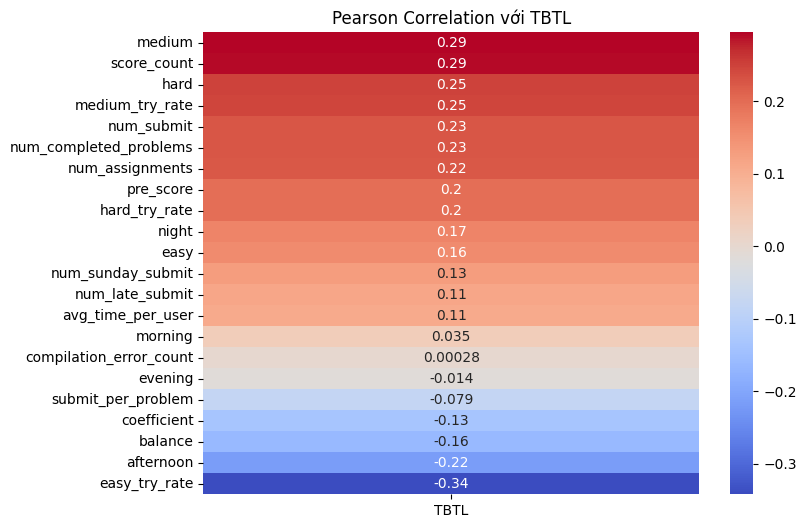

Text(0.5, 1.0, 'Spearman Correlation với TBTL')

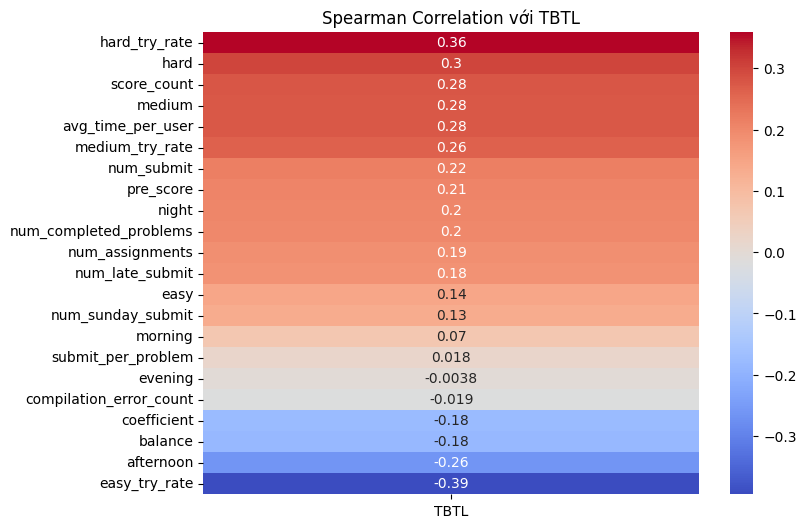

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(pearson_tbtl_corr_sorted.to_frame(), annot=True, cmap='coolwarm')
plt.title('Pearson Correlation với TBTL')
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(spearman_tbtl_corr_sorted.to_frame(), annot=True, cmap='coolwarm')
plt.title('Spearman Correlation với TBTL')

In [35]:
# chosen_features = th_corr[th_corr > 0.05].index.to_list()
chosen_features = pearson_tbtl_corr_sorted.index.to_list()
chosen_features

['medium',
 'score_count',
 'hard',
 'medium_try_rate',
 'num_submit',
 'num_completed_problems',
 'num_assignments',
 'pre_score',
 'hard_try_rate',
 'night',
 'easy',
 'num_sunday_submit',
 'num_late_submit',
 'avg_time_per_user',
 'morning',
 'compilation_error_count',
 'evening',
 'submit_per_problem',
 'coefficient',
 'balance',
 'afternoon',
 'easy_try_rate']

# **Modeling**

## Chuẩn bị dữ liệu train, test

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Các cột đặc trưng
features = chosen_features
target = 'TBTL'

# Tách dữ liệu train-test
X = tbtl_df[features]
y = tbtl_df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## SVR

In [37]:
from sklearn.svm import SVR

# Tạo pipeline chuẩn hóa dữ liệu và mô hình SVR
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR())
])

# Các tham số cần dò (phần 'svr__' là để trỏ đến SVR bên trong pipeline)
param_grid = {
    'svr__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'svr__C': [0.1, 1, 10, 100, 1000],
    'svr__gamma': ['scale', 'auto'],
    'svr__epsilon': [0.01, 0.1, 0.2, 0.5, 1.0]
}

# Tạo GridSearchCV
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='r2',
                           cv=5,
                           n_jobs=-1,
                           verbose=1)

# Fit dữ liệu
grid_search.fit(X_train, y_train)

# In ra kết quả tốt nhất
print("Best parameters:", grid_search.best_params_)
print("Best R² score (validation):", grid_search.best_score_)

# Đánh giá trên tập test
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Test RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("Test R² score:", r2_score(y_test, y_pred))


Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best parameters: {'svr__C': 1, 'svr__epsilon': 1.0, 'svr__gamma': 'scale', 'svr__kernel': 'rbf'}
Best R² score (validation): 0.3284564926963337
Test RMSE: 1.4666794753498977
Test R² score: 0.324309199810499


In [38]:
# Dự đoán
summary_features = summary_df[features]

summary_df['predicted_TBTL'] = best_model.predict(summary_features)

# In vài dòng kết quả
print(summary_df[['username', 'predicted_TBTL']].head())

# Xuất ra file .txt theo định dạng yêu cầu
summary_df[['username', 'predicted_TBTL']].to_csv(
    'svr_predict.txt', index=False, header=False
)

                                   username  predicted_TBTL
0  9f605b4802c811805adc38ae19035ded09a5e4b5        6.861899
1  2cd5132c3c49bd9d4d5081e386a4d69a593f850a        6.700016
2  58f61331a385caeed17baaf54abea308426d50fe        6.903496
3  1abf62f1e76bc5ac164061cff2a8171d6b6de657        6.863160
4  33b16210a7736a6f75ef1b1f3cb7070a4d29395e        7.199750


## Linear Regression

In [39]:
from sklearn.linear_model import LinearRegression

# Pipeline: chuẩn hóa dữ liệu + mô hình
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

# Tham số cần dò
param_grid = {
    'model__fit_intercept': [True, False],
    'model__positive': [True, False]  # Chỉ hỗ trợ từ sklearn 1.0 trở lên
}

# Tạo GridSearchCV
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='r2',
                           cv=5,
                           n_jobs=-1,
                           verbose=1)

# Fit dữ liệu
grid_search.fit(X_train, y_train)

# In ra kết quả tốt nhất
print("Best parameters:", grid_search.best_params_)
print("Best R² score (validation):", grid_search.best_score_)

# Đánh giá trên tập test
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Test RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("Test R² score:", r2_score(y_test, y_pred))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters: {'model__fit_intercept': True, 'model__positive': True}
Best R² score (validation): 0.30867583110704133
Test RMSE: 1.4773234875184045
Test R² score: 0.31446634266681206


In [40]:
# Dự đoán
summary_features = summary_df[features]

summary_df['predicted_TBTL'] = best_model.predict(summary_features)

# In vài dòng kết quả
print(summary_df[['username', 'predicted_TBTL']].head())

# Xuất ra file .txt theo định dạng yêu cầu
summary_df[['username', 'predicted_TBTL']].to_csv(
    'linearregression_predict.txt', index=False, header=False
)

                                   username  predicted_TBTL
0  9f605b4802c811805adc38ae19035ded09a5e4b5        8.610892
1  2cd5132c3c49bd9d4d5081e386a4d69a593f850a       10.039302
2  58f61331a385caeed17baaf54abea308426d50fe        7.606400
3  1abf62f1e76bc5ac164061cff2a8171d6b6de657        6.788733
4  33b16210a7736a6f75ef1b1f3cb7070a4d29395e        8.317944


## Ridge Regression

In [41]:
from sklearn.linear_model import Ridge

# Pipeline: chuẩn hóa + mô hình Ridge
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Ridge())
])

# Grid các tham số cho Ridge
param_grid = {
    'model__alpha': [0.01, 0.1, 1, 10, 100],               # hệ số điều chuẩn
    'model__fit_intercept': [True, False],
    'model__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg']
}

# Tạo GridSearchCV
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='r2',
                           cv=5,
                           n_jobs=-1,
                           verbose=1)

# Fit dữ liệu
grid_search.fit(X_train, y_train)

# In ra kết quả tốt nhất
print("Best parameters:", grid_search.best_params_)
print("Best R² score (validation):", grid_search.best_score_)

# Đánh giá trên tập test
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Test RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("Test R² score:", r2_score(y_test, y_pred))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters: {'model__alpha': 0.01, 'model__fit_intercept': True, 'model__solver': 'svd'}
Best R² score (validation): 0.3045319746768308
Test RMSE: 1.4552530611068273
Test R² score: 0.33479635574887123


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
50 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py", line 129, in _solve_sparse_cg
    coefs[i], info = sp_linalg.cg(
                     ^^^^^^^^^^^^^
TypeError: cg() got an unexpected keyword argument 'tol'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_tr

In [42]:
# Dự đoán
summary_features = summary_df[features]

summary_df['predicted_TBTL'] = best_model.predict(summary_features)

# In vài dòng kết quả
print(summary_df[['username', 'predicted_TBTL']].head())

# Xuất ra file .txt theo định dạng yêu cầu
summary_df[['username', 'predicted_TBTL']].to_csv(
    'ridgeregression_predict.txt', index=False, header=False
)

                                   username  predicted_TBTL
0  9f605b4802c811805adc38ae19035ded09a5e4b5        7.377975
1  2cd5132c3c49bd9d4d5081e386a4d69a593f850a        9.792343
2  58f61331a385caeed17baaf54abea308426d50fe        6.805461
3  1abf62f1e76bc5ac164061cff2a8171d6b6de657        4.973167
4  33b16210a7736a6f75ef1b1f3cb7070a4d29395e        8.018493


## CatBoost

In [43]:
from catboost import CatBoostRegressor

# Định nghĩa mô hình cơ bản
model = CatBoostRegressor(verbose=0, random_state=42)

# Các tham số cần dò
# param_grid = {
#     'iterations': [50, 100, 300, 500],
#     'depth': [4, 6, 8, 10, 12],
#     'learning_rate': [0.001, 0.01, 0.05, 0.1],
#     'l2_leaf_reg': [1, 3, 5, 7, 9]
# }

param_grid = {
    'iterations': [100, 300, 500],
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.001, 0.01, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'bootstrap_type': ['Bayesian', 'Bernoulli', 'MVS'],
}


# Tạo GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           scoring='r2', cv=5, n_jobs=-1, verbose=1)

# Fit dữ liệu
grid_search.fit(X_train, y_train)

# In ra kết quả tốt nhất
print("Best parameters:", grid_search.best_params_)
print("Best R² score (validation):", grid_search.best_score_)

# Đánh giá trên tập test
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Test RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("Test R² score:", r2_score(y_test, y_pred))

Fitting 5 folds for each of 720 candidates, totalling 3600 fits
Best parameters: {'bootstrap_type': 'Bayesian', 'depth': 4, 'iterations': 300, 'l2_leaf_reg': 1, 'learning_rate': 0.05}
Best R² score (validation): 0.4260646428538
Test RMSE: 1.4396545695779617
Test R² score: 0.3489802305527737


In [44]:
# Dự đoán
summary_features = summary_df[features]

summary_df['predicted_TBTL'] = best_model.predict(summary_features)

# In vài dòng kết quả
print(summary_df[['username', 'predicted_TBTL']].head())

# Xuất ra file .txt theo định dạng yêu cầu
summary_df[['username', 'predicted_TBTL']].to_csv(
    'catboost_predict.txt', index=False, header=False
)

                                   username  predicted_TBTL
0  9f605b4802c811805adc38ae19035ded09a5e4b5        7.311639
1  2cd5132c3c49bd9d4d5081e386a4d69a593f850a        7.064245
2  58f61331a385caeed17baaf54abea308426d50fe        6.743658
3  1abf62f1e76bc5ac164061cff2a8171d6b6de657        5.704221
4  33b16210a7736a6f75ef1b1f3cb7070a4d29395e        6.977031


## XGBoost

In [45]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# Khởi tạo mô hình cơ bản
model = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    verbosity=0  # Tắt log của XGBoost
)

# Grid các tham số cần dò
# param_grid = {
#     'n_estimators': [20, 50, 100, 200, 300],
#     'max_depth': [1, 3, 5, 7, 9],
#     'learning_rate': [0.001, 0.01, 0.05, 0.1],
#     'subsample': [0.4, 0.6, 0.8, 1.0],
#     'colsample_bytree': [0.8, 1.0]
# }

param_grid = {
    'n_estimators': [50, 100, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.001, 0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5],
    'reg_alpha': [0, 0.1, 1],  # L1 regularization
    'reg_lambda': [1, 3, 5]    # L2 regularization
}


# Khởi tạo GridSearchCV
grid_search = GridSearchCV(estimator=model,
                           param_grid=param_grid,
                           scoring='r2',
                           cv=5,
                           n_jobs=-1,
                           verbose=1)

# Huấn luyện
grid_search.fit(X_train, y_train)

# Kết quả tốt nhất
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation R²:", grid_search.best_score_)

# Đánh giá trên tập test
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
print(f"Test RMSE: {rmse}")
print(f"Test R² score: {r2}")

Fitting 5 folds for each of 11664 candidates, totalling 58320 fits
Best parameters: {'colsample_bytree': 1.0, 'gamma': 5, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.6}
Best cross-validation R²: 0.4355930378994204
Test RMSE: 1.4273740013503262
Test R² score: 0.3600395412696018


In [46]:
# Dự đoán
summary_features = summary_df[features]

summary_df['predicted_TBTL'] = best_model.predict(summary_features)

# In vài dòng kết quả
print(summary_df[['username', 'predicted_TBTL']].head())

# Xuất ra file .txt theo định dạng yêu cầu
summary_df[['username', 'predicted_TBTL']].to_csv(
    'xgboost_predict.txt', index=False, header=False
)

                                   username  predicted_TBTL
0  9f605b4802c811805adc38ae19035ded09a5e4b5        6.933880
1  2cd5132c3c49bd9d4d5081e386a4d69a593f850a        7.202353
2  58f61331a385caeed17baaf54abea308426d50fe        6.658444
3  1abf62f1e76bc5ac164061cff2a8171d6b6de657        5.881121
4  33b16210a7736a6f75ef1b1f3cb7070a4d29395e        6.839614
